# Fortum Energy Forecasting
Creating a lightgbm model that predicts energy consumption across 112 groups from Fortum's training dataset. This is an extension of Junction 2025.

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
color_pal = sns.color_palette()

import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit
import optuna
import gc

/home/anton_s/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_JUNCTION_training.xlsx"
prices_df = pd.read_excel(file_path, sheet_name="training_prices")
df = pd.read_excel(file_path, sheet_name="training_consumption")
groups_df = pd.read_excel(file_path, sheet_name="groups")

# Convert to long format
df = df.melt(
    id_vars=['measured_at'],
    var_name='group_id',
    value_name='consumption'
)

df['measured_at'] = pd.to_datetime(df['measured_at'])
prices_df['measured_at'] = pd.to_datetime(prices_df['measured_at'])

df = pd.merge(df, prices_df, on='measured_at', how='left')

df['group_id'] = df['group_id'].astype('category')

df = df.set_index('measured_at')
df = df.sort_index()


# Checking for outliers
doesn't look like there is

<Axes: ylabel='Frequency'>

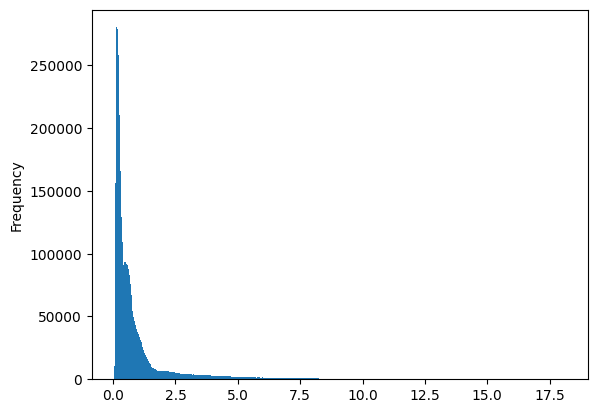

In [8]:
df['consumption'].plot(kind='hist', bins=500)

<Axes: xlabel='measured_at'>

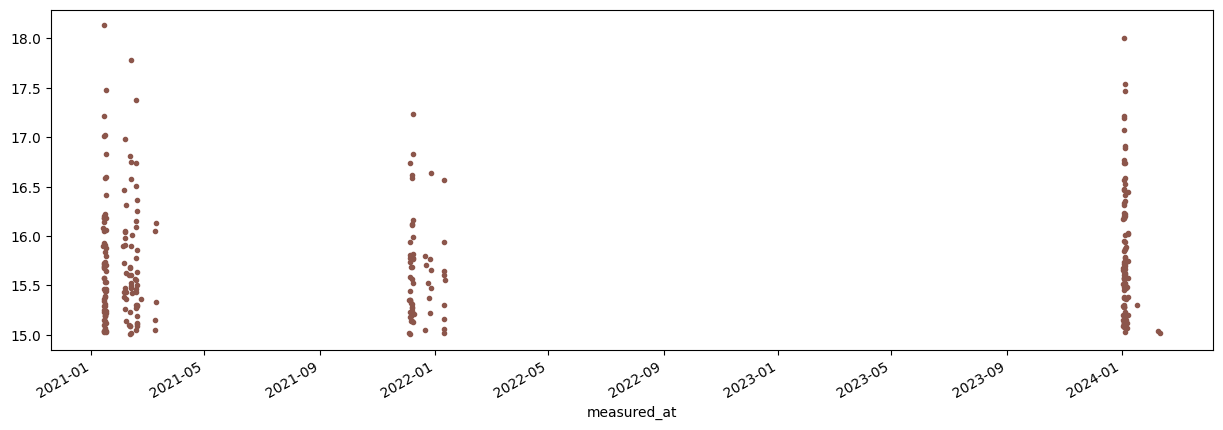

In [9]:
df.query('consumption > 15')['consumption'].plot(figsize=(15, 5),
                                                 style='.',
                                                 color=color_pal[5])

# Price plot
Price dataset unfortunately is missing 9 days of data, but this can be ignored since lightgbm handles NaNs well.

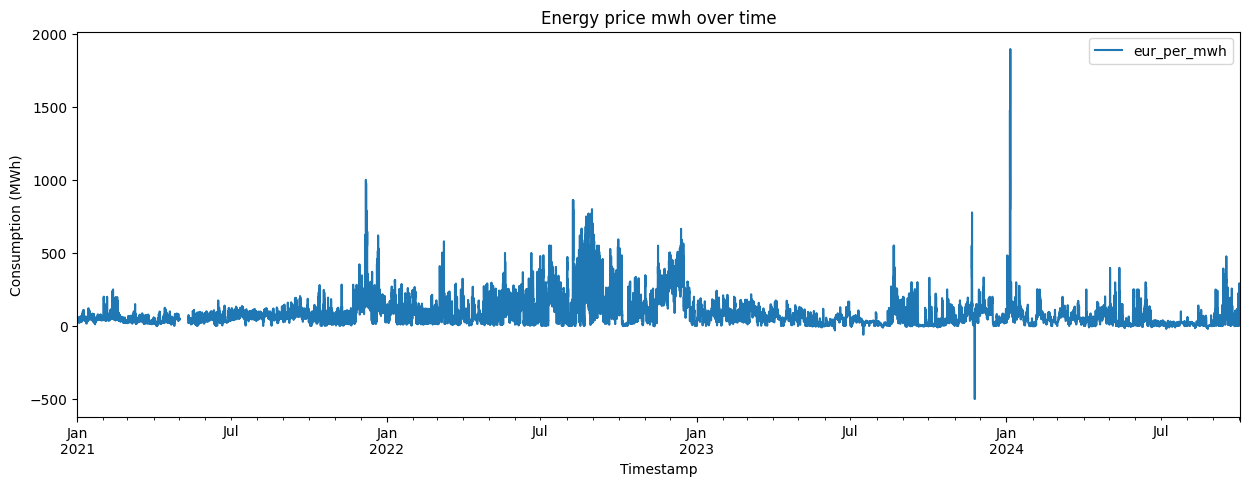

In [6]:
prices_df.plot(x='measured_at', y='eur_per_mwh', figsize=(15, 5))

plt.title('Energy price mwh over time')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (MWh)')
plt.show()

# Feature creation

# 1. Group related features
groups_df contains descriptive information of the 112 groups of which the most important features are
- Private / Enterprise customers (Household consumers / small business customers)
- 5 different electricity contract types
- level of consumption: low/medium/high


In [3]:
split_data = groups_df['group_label'].str.split('|', expand=True)
groups_df['customer_category'] = split_data[3].str.strip()

groups_df['is_enterprise'] = (groups_df['customer_category'] == 'Enterprise').astype(int)
groups_df['is_private'] = (groups_df['customer_category'] == 'Private').astype(int)

contract_map = {
    'Spot Price': 1,
    'Fixed Price': 2,
    'Variable Price': 3,
    'Flat/Hybrid': 4,
    'Portfolio': 5
}

volume_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}
groups_df['contract_type'] = split_data[4].str.strip()
groups_df['contract_type_int'] = groups_df['contract_type'].map(contract_map)

groups_df['cons_level_str'] = split_data[5].str.strip()
groups_df['cons_level_int'] = groups_df['cons_level_str'].map(volume_map)

In [4]:
def add_group_features(df, groups_df):
    # 1. Työskennellään kopiolla
    df = df.copy()
    groups_df = groups_df.copy()

    # 2. Indeksin hallinta: Varmistetaan että measured_at on sarake mergeä varten
    index_name = df.index.name
    was_index = False
    
    if index_name == 'measured_at':
        df = df.reset_index()
        was_index = True
    elif 'measured_at' not in df.columns:
        # Jos indeksi on "nimetön" tai "index", oletetaan sen olevan aikaleima
        df = df.reset_index()
        if 'measured_at' not in df.columns: # Jos resetointi teki sarakkeen 'index'
            df = df.rename(columns={'index': 'measured_at'})
        was_index = True

    # 3. TÄRKEÄÄ: Poistetaan df:stä ne featuret, jotka aiomme tuoda groups_df:stä.
    # Tämä estää _x ja _y sarakkeiden syntymisen ja varmistaa, että
    # myös tulevaisuuden rivit (joissa on NaN) saavat oikeat arvot.
    features_to_add = ['is_private', 'is_enterprise', 'contract_type_int', 'cons_level_int']
    
    # Poistetaan vain ne, jotka ovat jo df:ssä (estää konfliktit)
    cols_to_drop = [col for col in features_to_add if col in df.columns]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    # 4. Varmistetaan avaimet mergeä varten (molemmat stringeiksi)
    df['group_id_temp'] = df['group_id'].astype(str)
    groups_df['group_id_temp'] = groups_df['group_id'].astype(str)

    # 5. Valitaan groups_df:stä avain ja halutut featuret
    # (Emme tuo 'group_id'-saraketta uudestaan, ettei tule 'group_id_y')
    cols_to_merge = ['group_id_temp'] + features_to_add

    # 6. Merge
    df = pd.merge(
        df,
        groups_df[cols_to_merge],
        on='group_id_temp',
        how='left'
    )

    # 7. Siivous ja indeksin palautus
    df = df.drop(columns=['group_id_temp'])
    
    if was_index:
        df = df.set_index('measured_at')
        df = df.sort_index()

    # Alkuperäinen tyypitys
    df['group_id'] = df['group_id'].astype('category')

    return df

df = add_group_features(df, groups_df)

# 2. Energy price feature
Energy price is featured as a 24 hour lag feature. This is because in the true 48h forecast, energy price is only available 24 hours into the future.

In [5]:
df['price_24h_lag'] = df['eur_per_mwh'].shift(24)
df.drop(['eur_per_mwh'], axis=1, inplace=True)

# 3. time series features


In [6]:
def create_ts_features(df):
    """Create time series features based on time index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['season'] = ((df['month']%12 + 3)//3)
    return df

df = create_ts_features(df)

# 4. Lag features

Since forecasting window is 48 hours, the lags must be minimum 48 hours. Otherwise there would be data leakage in the training and validation of the model


In [7]:
def add_lag(df):
    df = df.copy()
    # Create lags per group
    for group in df['group_id'].unique():
        group_data = df[df['group_id'] == group].sort_index()
        target_map = group_data['consumption'].to_dict()
        df.loc[df['group_id'] == group, '2 day lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('2 days')).map(target_map)
        df.loc[df['group_id'] == group, '3 day lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('3 days')).map(target_map)
        df.loc[df['group_id'] == group, '1 week lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('7 days')).map(target_map)
        df.loc[df['group_id'] == group, '1y lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('364 days')).map(target_map)
    return df

In [8]:
df = add_lag(df)
df = df.sort_index() 

# 5. Statistical features

stats for the period between 96 hours ago and 48 hours ago. It's concluded that max_rolling is the most important feature

In [9]:
def add_stats(df):
    df = df.copy()
    safe_series = df.groupby('group_id')['consumption'].shift(48)
    
    #df['std_rolling'] = safe_series.rolling(window=48).std()
    #df['mean_rolling'] = safe_series.rolling(window=48).mean()
    df['max_rolling'] = safe_series.rolling(window=48).max()
    #df['min_rolling'] = safe_series.rolling(window=48).min()
    return df

In [10]:
df = add_stats(df)
df = df.sort_index() 

/tmp/ipykernel_136491/2145127039.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  safe_series = df.groupby('group_id')['consumption'].shift(48)


# 6. Weather features
Key weather features are:

* Temperature
* Wind
* Humidity
* Rain



In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time

# 1. Päivitetty lista koordinaateilla
locations = {
    "Etelä-Savo": {"city": "Savonlinna", "lat": 61.8699, "lon": 28.8800},
    "Pohjois-Savo": {"city": "Kuopio", "lat": 62.8924, "lon": 27.6770},
    "Rovaniemi": {"city": "Rovaniemi", "lat": 66.5039, "lon": 25.7294},
    "Lappi": {"city": "Kemi", "lat": 65.7328, "lon": 24.5641},
    "Pohjois-Pohjanmaa": {"city": "Kajaani", "lat": 64.2238, "lon": 27.7278},
    "Kanta-Häme_others": {"city": "Forssa", "lat": 60.8146, "lon": 23.6151},
    "Kanta-Häme": {"city": "Hämeenlinna", "lat": 60.9959, "lon": 24.4643},
    "Päijät_Häme_others": {"city": "Heinola", "lat": 61.2056, "lon": 26.0381},
    "Uusimaa_others": {"city": "Hyvinkää", "lat": 60.6305, "lon": 24.8597},
    "Varsinais-Suomi_others": {"city": "Salo", "lat": 60.3867, "lon": 23.1250},
    "Pirkanmaa_others": {"city": "Nokia", "lat": 61.4779, "lon": 23.5098},
    "Pohjanmaa": {"city": "Seinäjoki", "lat": 62.7903, "lon": 22.8403},
    "Etelä-Pohjanmaa": {"city": "Seinäjoki", "lat": 62.7903, "lon": 22.8403},
    "Keski-Suomi_others": {"city": "Jämsä", "lat": 61.8643, "lon": 25.1900},
    "Joensuu": {"city": "Joensuu", "lat": 62.6010, "lon": 29.7636},
    "Helsinki": {"city": "Helsinki", "lat": 60.1695, "lon": 24.9354},
    "Tampere": {"city": "Tampere", "lat": 61.4978, "lon": 23.7610},
    "Oulu": {"city": "Oulu", "lat": 65.0124, "lon": 25.4682},
    "Turku": {"city": "Turku", "lat": 60.4515, "lon": 22.2666},
    "Lappeenranta": {"city": "Lappeenranta", "lat": 61.0587, "lon": 28.1887},
    "Espoo": {"city": "Espoo", "lat": 60.2055, "lon": 24.6559},
    "Lahti": {"city": "Lahti", "lat": 60.9827, "lon": 25.6612},
    "Vantaa": {"city": "Vantaa", "lat": 60.2941, "lon": 25.0409},
    "Pori": {"city": "Pori", "lat": 61.4851, "lon": 21.7974},
    "Jyväskylä": {"city": "Jyväskylä", "lat": 62.2415, "lon": 25.7209}
}
# Setup
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)
url = "https://archive-api.open-meteo.com/v1/archive"

all_data = []

print(f"Aloitetaan haku {len(locations)} kaupungille...")

for i, (group_name, info) in enumerate(locations.items(), 1):
    
    print(f"[{i}/{len(locations)}] Haetaan: {group_name} ({info['city']})...", end=" ")
    
    params = {
        "latitude": info["lat"],
        "longitude": info["lon"],
        "start_date": "2021-01-01",
        "end_date": "2025-09-30",
        "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "wind_speed_10m"],
        "timezone": "Europe/Helsinki"
    }
    
    try:
        # Tehdään haku
        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]
        
        # Käsitellään data
        hourly = response.Hourly()
        hourly_data = {
            "date": pd.date_range(
                start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
                end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
                freq = pd.Timedelta(seconds = hourly.Interval()),
                inclusive = "left"
            )
        }
        
        hourly_data["Ryhmä"] = group_name
        hourly_data["Kaupunki"] = info["city"]
        hourly_data["Lämpötila (°C)"] = hourly.Variables(0).ValuesAsNumpy()
        hourly_data["Kosteus (%)"] = hourly.Variables(1).ValuesAsNumpy()
        hourly_data["Sade (mm)"] = hourly.Variables(2).ValuesAsNumpy()
        hourly_data["Tuuli (m/s)"] = hourly.Variables(3).ValuesAsNumpy()

        df_loc = pd.DataFrame(data = hourly_data)
        all_data.append(df_loc)
        
        print("OK.") # Kerrotaan käyttäjälle että onnistui

    except Exception as e:
        print(f"\n!!! VIRHE kohdassa {group_name}: {e}")
        # 'continue' varmistaa että silmukka ei katkea, vaan yrittää seuraavaa
        continue 
    
    # --- TÄRKEÄ HIDASTUS ---
    # Odotetaan 2 sekuntia ennen seuraavaa hakua.
    # Jos dataa on paljon, API saattaa vaatia tämän.
    time.sleep(5) 

# Tallennus vasta loopin jälkeen
if all_data:
    print("\nYhdistetään dataa...")
    final_df = pd.concat(all_data)
    final_df.to_csv("saa_data_FINAL.csv", index=False)
    print(f"Valmis! Tallennettu {len(final_df)} riviä tiedostoon saa_data_FINAL.csv")
else:
    print("Mitään dataa ei saatu haettua.")



Aloitetaan haku 25 kaupungille...
[1/25] Haetaan: Etelä-Savo (Savonlinna)... OK.
[2/25] Haetaan: Pohjois-Savo (Kuopio)... OK.
[3/25] Haetaan: Rovaniemi (Rovaniemi)... OK.
[4/25] Haetaan: Lappi (Kemi)... OK.
[5/25] Haetaan: Pohjois-Pohjanmaa (Kajaani)... OK.
[6/25] Haetaan: Kanta-Häme_others (Forssa)... OK.
[7/25] Haetaan: Kanta-Häme (Hämeenlinna)... OK.
[8/25] Haetaan: Päijät_Häme_others (Heinola)... OK.
[9/25] Haetaan: Uusimaa_others (Hyvinkää)... OK.
[10/25] Haetaan: Varsinais-Suomi_others (Salo)... OK.
[11/25] Haetaan: Pirkanmaa_others (Nokia)... OK.
[12/25] Haetaan: Pohjanmaa (Seinäjoki)... OK.
[13/25] Haetaan: Etelä-Pohjanmaa (Seinäjoki)... OK.
[14/25] Haetaan: Keski-Suomi_others (Jämsä)... OK.
[15/25] Haetaan: Joensuu (Joensuu)... OK.
[16/25] Haetaan: Helsinki (Helsinki)... OK.
[17/25] Haetaan: Tampere (Tampere)... OK.
[18/25] Haetaan: Oulu (Oulu)... OK.
[19/25] Haetaan: Turku (Turku)... OK.
[20/25] Haetaan: Lappeenranta (Lappeenranta)... OK.
[21/25] Haetaan: Espoo (Espoo)... OK.

In [11]:

# Sanakirja: "ID_numero": "Säädatan_kaupunki"
# Tuntemattomat otetaan vain suurimman kaupungin mukaan.
id_to_city_map = {
    "28": "Savonlinna",  # Etelä-Savo
    "29": "Savonlinna",
    "30": "Savonlinna",
    "36": "Joensuu",
    "37": "Joensuu",
    "38": "Joensuu",
    "39": "Joensuu",
    "40": "Joensuu",
    "41": "Joensuu",
    "42": "Joensuu",
    "43": "Joensuu",
    "73": "Joensuu",
    "74": "Joensuu",
    "76": "Joensuu",
    "116": "Kuopio",
    "149": "Kemi",      # Lappi
    "150": "Kemi",
    "151": "Kemi",
    "152": "Kemi",
    "157": "Rovaniemi",
    "196": "Oulu",
    "197": "Oulu",
    "198": "Oulu",
    "199": "Oulu",
    "200": "Oulu",
    "201": "Oulu",
    "213": "Oulu",
    "222": "Kajaani",   # Pohjois-Pohjanmaa
    "225": "Kajaani",
    "231": "Kajaani",
    "233": "Kajaani",
    "234": "Kajaani",
    "235": "Kajaani",
    "237": "Kajaani",
    "238": "Kajaani",
    "270": "Lappeenranta",
    "271": "Lappeenranta",
    "295": "Hämeenlinna",
    "298": "Hämeenlinna",
    "301": "Hämeenlinna",
    "302": "Hämeenlinna",
    "303": "Hämeenlinna",
    "304": "Forssa",      # Kanta-Häme_others
    "305": "Hämeenlinna",
    "307": "Hämeenlinna",
    "308": "Hämeenlinna",
    "346": "Lahti",
    "347": "Lahti",
    "348": "Lahti",
    "378": "Lahti",
    "380": "Heinola",     # Päijät_Häme_others
    "385": "Espoo",
    "387": "Espoo",
    "390": "Espoo",
    "391": "Espoo",
    "393": "Espoo",
    "394": "Espoo",
    "395": "Espoo",
    "396": "Espoo",
    "397": "Espoo",
    "398": "Espoo",
    "399": "Espoo",
    "400": "Espoo",
    "401": "Espoo",
    "402": "Espoo",
    "403": "Espoo",
    "404": "Espoo",
    "405": "Espoo",
    "447": "Hyvinkää",    # Uusimaa_others
    "450": "Hyvinkää",
    "459": "Vantaa",
    "460": "Vantaa",
    "466": "Vantaa",
    "468": "Pori",
    "469": "Pori",
    "538": "Salo",  
    "541": "Salo",  
    "542": "Salo", 
    "561": "Seinäjoki",
    "570": "Seinäjoki",
    "573": "Seinäjoki",
    "577": "Seinäjoki",
    "580": "Seinäjoki",
    "581": "Seinäjoki",
    "582": "Seinäjoki",
    "583": "Seinäjoki",
    "585": "Seinäjoki",
    "586": "Seinäjoki",
    "622": "Jyväskylä",
    "623": "Jyväskylä",
    "624": "Jyväskylä",
    "625": "Jyväskylä",
    "626": "Jyväskylä",
    "657": "Jyväskylä",
    "658": "Jämsä",       # Keski-Suomi_others
    "659": "Jämsä",
    "682": "Nokia",       # Pirkanmaa_others
    "691": "Nokia",
    "692": "Nokia",
    "693": "Nokia",
    "694": "Nokia",
    "695": "Nokia",
    "697": "Nokia",
    "698": "Nokia",
    "705": "Tampere",
    "706": "Tampere",
    "707": "Tampere",
    "708": "Tampere",
    "709": "Tampere",
    "738": "Seinäjoki",
    "740": "Seinäjoki",
    "741": "Seinäjoki"
}

In [12]:

weather_df = pd.read_csv("saa_data_FINAL.csv")

df = df.reset_index()
df['group_id_str'] = df['group_id'].astype(str)
df['Kaupunki'] = df['group_id_str'].map(id_to_city_map)

weather_df = weather_df.rename(columns={'date': 'measured_at'})
df['measured_at'] = pd.to_datetime(df['measured_at'], utc=True)
weather_df['measured_at'] = pd.to_datetime(weather_df['measured_at'], utc=True)

weather_cols = ['measured_at', 'Kaupunki', 'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)']
weather_df_clean = weather_df[weather_cols].copy()

weather_df_clean = weather_df_clean.drop_duplicates(subset=['measured_at', 'Kaupunki'], keep='first')


df_final = pd.merge(
    df,
    weather_df_clean,
    on=['measured_at', 'Kaupunki'],
    how='left'
)

df_final['group_id'] = df_final['group_id'].astype('category')


df_final = df_final.sort_values(by=['measured_at', 'group_id'])


df_final = df_final.set_index('measured_at')


In [ ]:
#Delete useless dataframes
del weather_df_clean, weather_df
gc.collect() # Pakota muistin vapautus

31

In [ ]:
turhat_sarakkeet = ['index', 'level_0', 'Kaupunki', 'group_id_str']
df_final = df_final.drop(columns=turhat_sarakkeet, errors='ignore')

In [ ]:
df = df_final
del df_final
gc.collect()

31

# 7. Sun elevation feature
- Gives the angle of the sun
- Divide the elevation to three parts 

In [16]:
from astral import LocationInfo
from astral.sun import elevation

zone_coords = {
    'South':  (60.20, 24.65), # Espoo
    'Middle': (62.24, 25.74), # Jyväskylä
    'North':  (65.01, 25.46)  # Oulu
}

city_to_zone = {
    # Etelä (South) - Espoon koordinaatit
    'Espoo': 'South', 'Vantaa': 'South', 'Helsinki': 'South', 'Lahti': 'South', 
    'Heinola': 'South', 'Hämeenlinna': 'South', 'Forssa': 'South', 
    'Hyvinkää': 'South', 'Salo': 'South', 'Pori': 'South', 'Lappeenranta': 'South',
    
    # Keski (Middle) - Jyväskylän koordinaatit
    'Tampere': 'Middle', 'Nokia': 'Middle', 'Jyväskylä': 'Middle', 'Jämsä': 'Middle', 
    'Seinäjoki': 'Middle', 'Kuopio': 'Middle', 'Joensuu': 'Middle', 'Savonlinna': 'Middle',
    
    # Pohjoinen (North) - Oulun koordinaatit
    'Oulu': 'North', 'Kajaani': 'North', 'Kemi': 'North', 'Rovaniemi': 'North'
}
id_to_coords = {}

for group_id_str, city_name in id_to_city_map.items():
    zone = city_to_zone.get(city_name, 'South') # Oletus South jos kaupunkia ei löydy
    coords = zone_coords.get(zone)
    id_to_coords[group_id_str] = coords

In [ ]:
df.head()

,group_id,consumption,is_private,is_enterprise,contract_type_int,cons_level_int,price_24h_lag,hour,dayofweek,month,...,3 day lag,1 week lag,1y lag,max_rolling,Lämpötila (°C),Kosteus (%),Sade (mm),Tuuli (m/s),latitude,longitude
measured_at,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,116,1.133339,1,0,1,2,24.35,0,4,1,...,NaN,NaN,NaN,NaN,-0.45,97.12577,0.0,5.040000,62.24,25.74
2021-01-01 00:00:00+00:00,149,0.490640,1,0,4,2,24.35,0,4,1,...,NaN,NaN,NaN,NaN,-1.15,87.56698,0.1,13.324863,65.01,25.46
2021-01-01 00:00:00+00:00,150,8.214687,1,0,1,3,24.35,0,4,1,...,NaN,NaN,NaN,NaN,-1.15,87.56698,0.1,13.324863,65.01,25.46
2021-01-01 00:00:00+00:00,151,0.279774,1,0,1,1,24.35,0,4,1,...,NaN,NaN,NaN,NaN,-1.15,87.56698,0.1,13.324863,65.01,25.46
2021-01-01 00:00:00+00:00,152,2.307307,1,0,1,2,24.35,0,4,1,...,NaN,NaN,NaN,NaN,-1.15,87.56698,0.1,13.324863,65.01,25.46


In [ ]:
from astral import Observer
from astral.sun import elevation

# --- 1. VALMISTELUT ---
# Varmistetaan, että indeksi on datetime-muodossa
df.index = pd.to_datetime(df.index)

# Nostetaan indeksi väliaikaisesti sarakkeeksi nimeltä 'measured_at_temp'
# Tämä tekee mergestä ja laskennasta paljon helpompaa
df['measured_at_temp'] = df.index

# Määritellään etelän koordinaatit fallbackiksi (käytä omia arvojasi tässä)
south_coords = zone_coords['South'] 

# --- 2. KOORDINAATTIEN MÄPPÄYS ---
# Haetaan koordinaatit group_id:n perusteella
df['temp_coords'] = df['group_id'].astype(str).map(id_to_coords)

# KORJAUS 1: Käytetään applya fillna:n sijaan. 
# Tämä estää indeksien sekoittumisen ja Shape-virheet.
df['temp_coords'] = df['temp_coords'].apply(lambda x: x if isinstance(x, tuple) else south_coords)

# Pilkotaan tuple (lat, lon) kahdeksi sarakkeeksi
coords_df = pd.DataFrame(
    df['temp_coords'].tolist(), 
    index=df.index,  # Tärkeää: pidetään alkuperäinen indeksi
    columns=['latitude', 'longitude']
)

df['latitude'] = coords_df['latitude']
df['longitude'] = coords_df['longitude']
df.drop(columns=['temp_coords'], inplace=True)

# --- 3. AURINGON LASKENTA (Optimoitu) ---
print("Lasketaan auringon asentoa...")

# Luodaan uniikki taulukko käyttäen apusaraketta 'measured_at_temp'
unique_params = df[['measured_at_temp', 'latitude', 'longitude']].drop_duplicates().copy()

def calculate_sun_fast(row):
    obs = Observer(latitude=row['latitude'], longitude=row['longitude'])
    try:
        # Huom: käytetään row['measured_at_temp']
        return elevation(obs, row['measured_at_temp'])
    except:
        return 0.0

# Lasketaan vain uniikeille riveille
unique_params['sun_elevation'] = unique_params.apply(calculate_sun_fast, axis=1)

# --- 4. YHDISTÄMINEN ---
# Mergetään tulokset takaisin
df = df.merge(
    unique_params[['measured_at_temp', 'latitude', 'longitude', 'sun_elevation']], 
    on=['measured_at_temp', 'latitude', 'longitude'], 
    how='left'
)

# Asetetaan indeksi takaisin paikoilleen mergen jälkeen (merge saattaa hukata indeksin)
if 'measured_at_temp' in df.columns:
    df.index = df['measured_at_temp']

# Luodaan featuret
df['is_sun_up'] = (df['sun_elevation'] > 0).astype(int)

# --- 5. SIIVOUS ---
# Poistetaan apusarakkeet ja koordinaatit
df.drop(columns=['latitude', 'longitude', 'measured_at_temp'], inplace=True)

print("Valmis! Tulokset:")
print(df[['group_id', 'sun_elevation', 'is_sun_up']].head())

Lasketaan auringon asentoa...
Valmis! Tulokset:
                          group_id  sun_elevation  is_sun_up
measured_at_temp                                            
2021-01-01 00:00:00+00:00       28     -47.277134          0
2021-01-01 00:00:00+00:00       29     -47.277134          0
2021-01-01 00:00:00+00:00       30     -47.277134          0
2021-01-01 00:00:00+00:00       36     -47.277134          0
2021-01-01 00:00:00+00:00       37     -47.277134          0


# Correlation matrix 

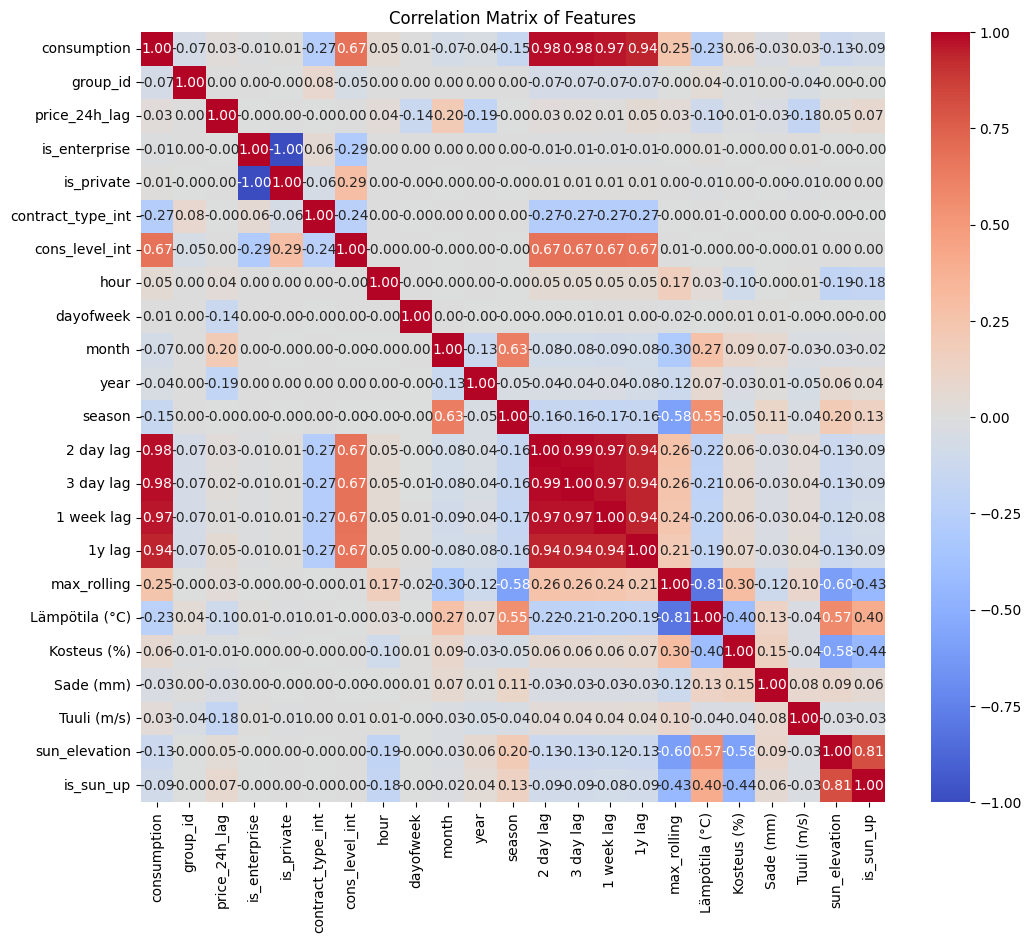

In [ ]:
features = ['consumption', 'group_id',
    'price_24h_lag', 'is_enterprise', 'is_private',
    'contract_type_int', 'cons_level_int',
    'hour', 'dayofweek', 'month', 'year', 'season',
    '2 day lag', '3 day lag', '1 week lag', '1y lag',
    'max_rolling',
    'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)', 
    'sun_elevation', 'is_sun_up'
]

corr_matrix = df[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True,      
            fmt=".2f",     
            cmap='coolwarm',  
            vmin=-1, vmax=1)  
plt.title('Correlation Matrix of Features')
plt.show()



# Model Creation
Hyperparameter tuning is done using Optuna, which is based on Bayesian optimization.

In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback

df.dropna()
features = ['group_id',
    'price_24h_lag', 'is_enterprise', 'is_private',
    'contract_type_int', 'cons_level_int',
    'hour', 'dayofweek', 'month', 'year', 'season',
    '2 day lag', '3 day lag', '1 week lag', '1y lag',
    'max_rolling',
    'Lämpötila (°C)', 'Kosteus (%)', 'Tuuli (m/s)', 
    'sun_elevation', 'is_sun_up'
]

# 4. Create X and y matrices (faster slicing than full DataFrame)
X = df[features]
y = df['consumption']

# --- OPTIMIZATION 2: SETUP VALIDATION ---
# 8-fold split
tscv = TimeSeriesSplit(n_splits=8, test_size=24*30*112, gap=24)

def objective(trial):
    # Hyper-parameters
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 10000, 
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }

    fold_scores = []
    
    # Define the pruning callback
    pruning_callback = LightGBMPruningCallback(trial, "mape")

    for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

        
        callbacks_list = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        
       
        if i == 0:
            callbacks_list.append(pruning_callback)

        model = lgb.LGBMRegressor(**params)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='mape',
            callbacks=callbacks_list  
        )
        
        best_score = model.best_score_['valid_0']['mape']
        fold_scores.append(best_score)

    return np.mean(fold_scores)

# --- RUN STUDY ---
print("🔍 Starting Optuna Optimization (8-Fold TimeSeriesSplit)...")

sampler = TPESampler(seed=42)
study = optuna.create_study(
    direction='minimize', 
    sampler=sampler, 
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n" + "="*60)
print(f"✅ DONE! Best MAPE: {study.best_value:.4f}")
print("="*60)

[I 2026-01-03 15:17:19,050] A new study created in memory with name: no-name-a5d5704e-55b9-47f1-b96d-ffe58ec1ebcf


🔍 Starting Optuna Optimization (12-Fold TimeSeriesSplit)...


Best trial: 0. Best value: 0.0276877:   5%|▌         | 1/20 [28:46<9:06:38, 1726.24s/it]

[I 2026-01-03 15:46:05,282] Trial 0 finished with value: 0.02768768678136359 and parameters: {'learning_rate': 0.015355286838886862, 'num_leaves': 144, 'max_depth': 24, 'min_child_samples': 62, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 0 with value: 0.02768768678136359.


Best trial: 0. Best value: 0.0276877:  10%|█         | 2/20 [47:36<6:52:37, 1375.44s/it]

[I 2026-01-03 16:04:55,160] Trial 1 finished with value: 0.029634958592732182 and parameters: {'learning_rate': 0.03027182927734624, 'num_leaves': 112, 'max_depth': 5, 'min_child_samples': 98, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 0 with value: 0.02768768678136359.


Best trial: 0. Best value: 0.0276877:  15%|█▌        | 3/20 [1:12:34<6:45:34, 1431.43s/it]

[I 2026-01-03 16:29:53,217] Trial 2 finished with value: 0.028607782592197057 and parameters: {'learning_rate': 0.012439367209907218, 'num_leaves': 88, 'max_depth': 16, 'min_child_samples': 32, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'lambda_l1': 4.258943089524393e-06, 'lambda_l2': 1.9826980964985924e-05}. Best is trial 0 with value: 0.02768768678136359.


Best trial: 3. Best value: 0.0276407:  20%|██        | 4/20 [1:35:56<6:18:41, 1420.12s/it]

[I 2026-01-03 16:53:16,001] Trial 3 finished with value: 0.02764068343273259 and parameters: {'learning_rate': 0.019603369861210685, 'num_leaves': 122, 'max_depth': 10, 'min_child_samples': 54, 'subsample': 0.7962072844310213, 'colsample_bytree': 0.5232252063599989, 'lambda_l1': 0.0029369981104377003, 'lambda_l2': 3.425445902633376e-07}. Best is trial 3 with value: 0.02764068343273259.


Best trial: 3. Best value: 0.0276407:  20%|██        | 4/20 [4:05:00<16:20:00, 3675.04s/it]


[W 2026-01-03 19:22:19,160] Trial 4 failed with parameters: {'learning_rate': 0.0060758085133366885, 'num_leaves': 144, 'max_depth': 30, 'min_child_samples': 82, 'subsample': 0.6523068845866853, 'colsample_bytree': 0.5488360570031919, 'lambda_l1': 0.014391207615728067, 'lambda_l2': 9.148975058772307e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/anton_s/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_76525/617924452.py", line 61, in objective
    model.fit(
  File "/home/anton_s/.local/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1398, in fit
    super().fit(
  File "/home/anton_s/.local/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1049, in fit
    self._Booster = train(
  File "/home/anton_s/.local/lib/python3.10/site-packages/lightgbm/engine.py", line 322, in train
    booster.update(fobj=fobj)
  File "/home

KeyboardInterrupt: 

# Time series cross validation

The model should capture the seasonality of the time series in the training phase. This is why validating is done for the final year of the data set by 12 1-month test sets. In this method, the model will be tested on every single month of the year, allowing more accurate predictions for the entirety of the seasonal pattern of the time series. Dividing the set into folds allows for better evaluatation of the model's performance and decrease variance between different months.

In [ ]:
tss = TimeSeriesSplit(n_splits=8, test_size=24*30*112, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
df = df.dropna()

features = ['group_id',
    'price_24h_lag', 'is_enterprise', 'is_private',
    'contract_type_int', 'cons_level_int',
    'hour', 'dayofweek', 'month', 'year', 'season',
    '2 day lag', '3 day lag', '1 week lag', '1y lag',
    'max_rolling',
    'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)', 
    'sun_elevation', 'is_sun_up'
]
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    target = ['consumption']

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]
    
    #Optimal parameters from tuning
    reg = lgb.LGBMRegressor(learning_rate=0.019603369861210685, num_leaves=122, max_depth=10, 
                            min_child_samples=54, subsample=0.7962072844310213, colsample_bytree=0.5232252063599989, 
                            lambda_l1=0.0029369981104377003, lambda_l2=3.425445902633376e-07,
                            early_stopping_round=50,
                            n_estimators=10000, objective='regression', metric='mape', verbosity=-1)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=['mape', 'rmse'],
            callbacks=[lgb.log_evaluation(period=100)]
            )
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)

[100]	valid_0's rmse: 0.421932	valid_0's mape: 0.0981858
[200]	valid_0's rmse: 0.217745	valid_0's mape: 0.0481671
[300]	valid_0's rmse: 0.195793	valid_0's mape: 0.0420898
[400]	valid_0's rmse: 0.191036	valid_0's mape: 0.0405541
[500]	valid_0's rmse: 0.188066	valid_0's mape: 0.0398355
[600]	valid_0's rmse: 0.186722	valid_0's mape: 0.0393835
[700]	valid_0's rmse: 0.185918	valid_0's mape: 0.0390959
[800]	valid_0's rmse: 0.1855	valid_0's mape: 0.0389279
[100]	valid_0's rmse: 0.325929	valid_0's mape: 0.0944098
[200]	valid_0's rmse: 0.184914	valid_0's mape: 0.0426001
[300]	valid_0's rmse: 0.166271	valid_0's mape: 0.0370507
[400]	valid_0's rmse: 0.158988	valid_0's mape: 0.0355465
[500]	valid_0's rmse: 0.154483	valid_0's mape: 0.0347502
[600]	valid_0's rmse: 0.150946	valid_0's mape: 0.0342096
[700]	valid_0's rmse: 0.148713	valid_0's mape: 0.0335922
[800]	valid_0's rmse: 0.147462	valid_0's mape: 0.033242
[900]	valid_0's rmse: 0.146738	valid_0's mape: 0.0330502
[1000]	valid_0's rmse: 0.145995	va

# MAPE of each validation fold

In [ ]:
scores

[0.05997190694922241,
 0.053660096983515426,
 0.07069927216617473,
 0.08237672714430423,
 0.05584654951796378,
 0.04260750153586998,
 0.04652384841483031,
 0.05269776097575545]

In [ ]:
#Average MAPE across folds
sum(scores)/len(scores)

0.05804795796095455

# Feature Importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

📊 Optuna Optimization Results:
   Paras MAPE: 0.0385
   Parhaat parametrit: {'learning_rate': 0.06822972045761802, 'num_leaves': 150, 'max_depth': 26, 'min_child_samples': 39, 'subsample': 0.7050269986405594, 'colsample_bytree': 0.7282716783254813, 'lambda_l1': 9.868745464853815, 'lambda_l2': 0.02383755943241378}


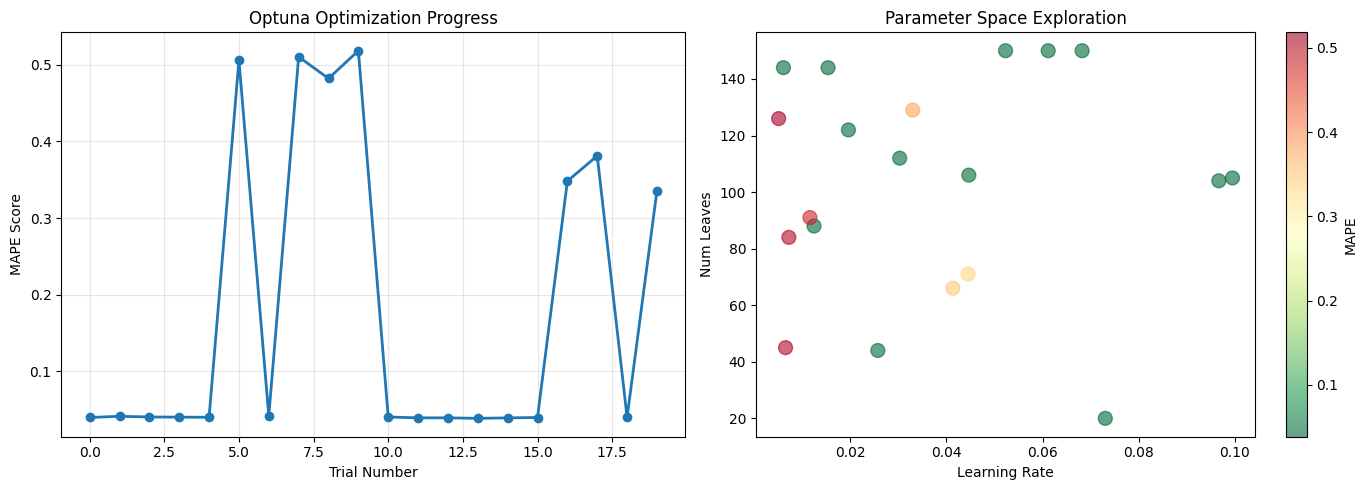

In [ ]:
# Näytetään Optuna tulokset
print("📊 Optuna Optimization Results:")
print(f"   Paras MAPE: {study.best_value:.4f}")
print(f"   Parhaat parametrit: {study.best_params}")

# Visualisoidaan optimoinnin eteneminen
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trials history
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], 'o-', linewidth=2, markersize=6)
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('MAPE Score')
axes[0].set_title('Optuna Optimization Progress')
axes[0].grid(True, alpha=0.3)

# Parameter importance (learning_rate vs num_leaves)
lr_values = [trial.params['learning_rate'] for trial in study.trials]
nl_values = [trial.params['num_leaves'] for trial in study.trials]
scores = [trial.value for trial in study.trials]

scatter = axes[1].scatter(lr_values, nl_values, c=scores, cmap='RdYlGn_r', s=100, alpha=0.6)
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Num Leaves')
axes[1].set_title('Parameter Space Exploration')
plt.colorbar(scatter, ax=axes[1], label='MAPE')

plt.tight_layout()
plt.show()


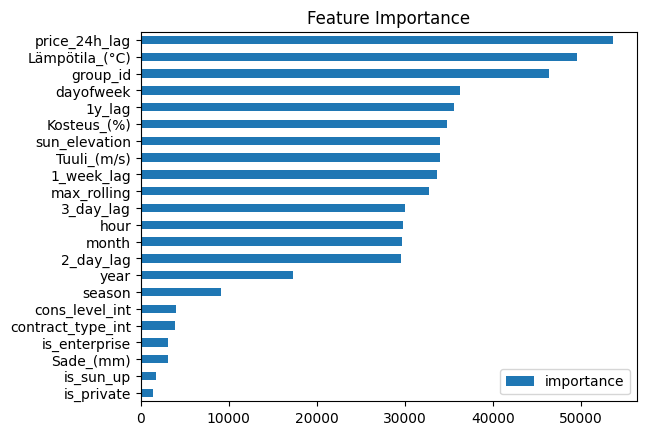

In [ ]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test Set

In [ ]:
# Make predictions for all 112 groups
test['prediction'] = reg.predict(X_test)

/tmp/ipykernel_76525/3229797182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


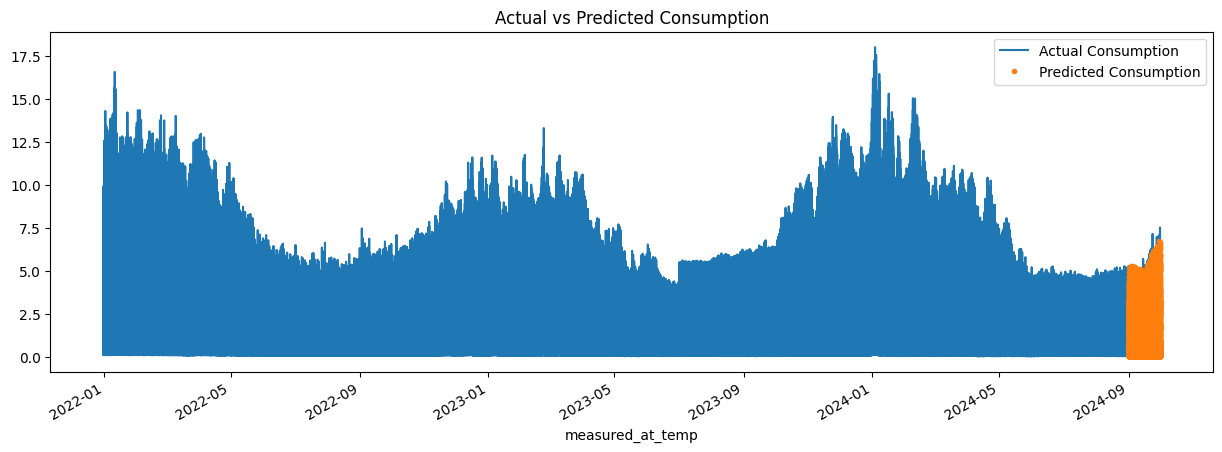

In [ ]:
ax = df[['consumption']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Consumption', 'Predicted Consumption'])
ax.set_title('Actual vs Predicted Consumption')
plt.show()

# Metrics

In [ ]:
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on test set: {mae:0.2f}")
print(f"MAPE on test set: {mape:0.2f}")
print(f"RMSE on test set: {rmse:0.2f}")

MAE on test set: 0.04
MAPE on test set: 0.05
RMSE on test set: 0.08


# Worst and best predicted days

In [ ]:
test['error'] = np.abs(test['consumption'] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

/tmp/ipykernel_76525/409630074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test['consumption'] - test['prediction'])
/tmp/ipykernel_76525/409630074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


date
2024-09-22    0.070834
2024-09-23    0.061641
2024-09-14    0.052226
2024-09-21    0.050151
2024-09-30    0.047908
Name: error, dtype: float64

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2024-09-06    0.023475
2024-09-11    0.023694
2024-09-07    0.025162
2024-09-05    0.025422
2024-09-09    0.025451
Name: error, dtype: float64

# 48 Hour forecast
1. train the final model using all available data 
2. Create the final forecasting dataframe and add features onto it.
3. Forecast and compare to the actual values in '/data/20251111_INTERNAL_actuals_hourly.csv'

In [ ]:
#Actual values for consumption
actual_hourly_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_INTERNAL_actuals_hourly.csv"
actual_monthly_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_INTERNAL_actuals_monthly.csv"

actual_hourly_df = pd.read_csv(actual_hourly_path, sep=';', decimal=',')
actual_monthly_df = pd.read_csv(actual_monthly_path, sep=';', decimal=',')


# Train final model with the best parameters and all data 


In [ ]:
features = ['group_id',
    'price_24h_lag', 'is_enterprise', 'is_private',
    'contract_type_int', 'cons_level_int',
    'hour', 'dayofweek', 'month', 'year', 'season',
    '2 day lag', '3 day lag', '1 week lag', '1y lag',
    'max_rolling',
    'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)', 
    'sun_elevation', 'is_sun_up'
]

X_final = df[features]
y_final = df['consumption']

final_model = lgb.LGBMRegressor(learning_rate=0.019603369861210685, num_leaves=122, max_depth=10, 
                            min_child_samples=54, subsample=0.7962072844310213, colsample_bytree=0.5232252063599989, 
                            lambda_l1=0.0029369981104377003, lambda_l2=3.425445902633376e-07,
                            n_estimators=4600, objective='regression', metric='mape', verbosity=-1)

final_model.fit(X_final, y_final,
                callbacks=[lgb.log_evaluation(period=100)])


,boosting_type,'gbdt'
,num_leaves,122
,max_depth,10
,learning_rate,0.019603369861210685
,n_estimators,4600
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,54


# Create the 48 hour forecasting dataframe and add features

In [ ]:
#48 hour dataframe
dates_df = pd.DataFrame({'measured_at': pd.date_range('2024-10-01T00:00:00.000Z', '2024-10-02T23:00:00.000Z', freq='1h')})
df_groups = pd.DataFrame({'group_id': df['group_id'].unique()})

# 2. Perform a Cross Join (Cartesian Product)
hourly_df = dates_df.merge(df_groups, how='cross')

# 3. Set Index and Fix Types
hourly_df = hourly_df.set_index('measured_at')
hourly_df['group_id'] = hourly_df['group_id'].astype(df['group_id'].dtype)

# 4. Add flags
hourly_df['future_consumption'] = True
df['future_consumption'] = False
df_and_hourly = pd.concat([df, hourly_df])

df_and_hourly = create_ts_features(df_and_hourly)
df_and_hourly = add_lag(df_and_hourly)
df_and_hourly = add_stats(df_and_hourly)
df_and_hourly = add_group_features(df_and_hourly, groups_df)

/tmp/ipykernel_129448/2145127039.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  safe_series = df.groupby('group_id')['consumption'].shift(48)


In [ ]:
# Load weather data and extract Oct 1-2, 2024 for forecast period
weather_df_full = pd.read_csv("forecast_saa_data_FINAL.csv")

# Rename 'date' to 'measured_at' for consistency
weather_df_full = weather_df_full.rename(columns={'date': 'measured_at'})

# Convert to datetime
weather_df_full['measured_at'] = pd.to_datetime(weather_df_full['measured_at'], utc=True)

# Filter for Oct 1-2, 2024
weather_oct = weather_df_full[
    (weather_df_full['measured_at'] >= '2024-10-01') & 
    (weather_df_full['measured_at'] <= '2024-10-02 23:59:59')
].copy()

print(f"Weather data for Oct 1-2, 2024: {len(weather_oct)} rows")
print(f"Date range: {weather_oct['measured_at'].min()} to {weather_oct['measured_at'].max()}")

# Prepare for merge: rename 'Kaupunki' to match
weather_cols = ['measured_at', 'Kaupunki', 'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)']
weather_oct_clean = weather_oct[weather_cols].drop_duplicates(subset=['measured_at', 'Kaupunki'], keep='first')

forecast_for_merge = df_and_hourly.reset_index()

# KORJAUS: Jos indeksin nimi katosi, sarake on nyt nimellä 'index'. Nimetään se takaisin.
if 'measured_at' not in forecast_for_merge.columns and 'index' in forecast_for_merge.columns:
    forecast_for_merge = forecast_for_merge.rename(columns={'index': 'measured_at'})
    
# Add Kaupunki mapping to forecast data
forecast_for_merge['group_id_str'] = forecast_for_merge['group_id'].astype(str)
forecast_for_merge['Kaupunki'] = forecast_for_merge['group_id_str'].map(id_to_city_map)

# Merge weather data
forecast_for_merge = pd.merge(
    forecast_for_merge,
    weather_oct_clean,
    on=['measured_at', 'Kaupunki'],
    how='left',
    suffixes=('_old', '')
)

# Update weather columns in forecast dataframe
forecast_df_final = forecast_for_merge.set_index('measured_at')

# Verify weather data is populated
print(f"\nWeather columns NaN count after merge:")
print(f"  Lämpötila: {forecast_df_final['Lämpötila (°C)'].isna().sum()}")
print(f"  Kosteus: {forecast_df_final['Kosteus (%)'].isna().sum()}")
print(f"  Sade: {forecast_df_final['Sade (mm)'].isna().sum()}")
print(f"  Tuuli: {forecast_df_final['Tuuli (m/s)'].isna().sum()}")

del df_and_hourly, forecast_for_merge, weather_oct, weather_df_full
gc.collect()


Weather data for Oct 1-2, 2024: 1200 rows
Date range: 2024-10-01 00:00:00+00:00 to 2024-10-02 23:00:00+00:00

Weather columns NaN count after merge:
  Lämpötila: 3679872
  Kosteus: 3679872
  Sade: 3685248
  Tuuli: 3679872


0

In [ ]:
forecast_df_final.head()

,group_id,consumption,price_24h_lag,hour,dayofweek,month,year,season,2 day lag,3 day lag,...,group_id_str,Kaupunki,Lämpötila (°C),Kosteus (%),Sade (mm),Tuuli (m/s),temp_coords,latitude,longitude,sun_elevation_y
measured_at,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,28,7.010736,NaN,0,4,1,2021,1,NaN,NaN,...,28,Savonlinna,NaN,NaN,NaN,NaN,"(62.24, 25.74)",62.24,25.74,-47.277134
2021-01-01 00:00:00+00:00,29,0.198555,24.35,0,4,1,2021,1,NaN,NaN,...,29,Savonlinna,NaN,NaN,NaN,NaN,"(62.24, 25.74)",62.24,25.74,-47.277134
2021-01-01 00:00:00+00:00,30,1.192911,24.35,0,4,1,2021,1,NaN,NaN,...,30,Savonlinna,NaN,NaN,NaN,NaN,"(62.24, 25.74)",62.24,25.74,-47.277134
2021-01-01 00:00:00+00:00,36,0.673303,24.35,0,4,1,2021,1,NaN,NaN,...,36,Joensuu,NaN,NaN,NaN,NaN,"(62.24, 25.74)",62.24,25.74,-47.277134
2021-01-01 00:00:00+00:00,37,0.170359,24.35,0,4,1,2021,1,NaN,NaN,...,37,Joensuu,NaN,NaN,NaN,NaN,"(62.24, 25.74)",62.24,25.74,-47.277134


In [ ]:

# --- 0. ALUSTUKSET JA TARKISTUKSET ---
# Varmistetaan, että staattiset sarakkeet on määritelty
if 'static_cols' not in locals():
    static_cols = ['is_enterprise', 'is_private', 'contract_type_int', 'cons_level_int']

# Varmistetaan, että forecast_df_final on oikeassa muodossa
if forecast_df_final.index.name != 'measured_at':
    # Jos measured_at on sarakkeena, asetetaan se indeksiksi
    if 'measured_at' in forecast_df_final.columns:
        forecast_df_final = forecast_df_final.set_index('measured_at')
    # Jos indeksi on nimetön tai väärän niminen, nimetään se
    forecast_df_final.index.name = 'measured_at'

forecast_df_final = forecast_df_final.sort_index()

# ==========================================
# 1. AURINKO FEATURET (Siivous + Optimointi)
# ==========================================
print("Lasketaan aurinkotiedot...")

# A) SIIVOUS: Poistetaan vanhat aurinko/koordinaattisarakkeet
cols_to_drop = ['sun_elevation', 'is_sun_up', 'latitude', 'longitude', 'temp_coords', 'group_id_str']
existing_cols = [c for c in cols_to_drop if c in forecast_df_final.columns]
if existing_cols:
    forecast_df_final = forecast_df_final.drop(columns=existing_cols)

# B) Valmistellaan koordinaatit
forecast_df_final['group_id_str'] = forecast_df_final['group_id'].astype(str)
forecast_df_final['temp_coords'] = forecast_df_final['group_id_str'].map(id_to_coords)

# Fallback: Jos koordinaatteja ei löydy, käytetään Etelää
south_coords = zone_coords['South']
forecast_df_final['temp_coords'] = forecast_df_final['temp_coords'].apply(
    lambda x: x if isinstance(x, tuple) else south_coords
)

# Erotetaan lat/lon
coords_temp = pd.DataFrame(forecast_df_final['temp_coords'].tolist(), index=forecast_df_final.index)
forecast_df_final['latitude'] = coords_temp[0]
forecast_df_final['longitude'] = coords_temp[1]

# C) OPTIMOITU LASKENTA: Vain uniikeille yhdistelmille
unique_sun_params = forecast_df_final.reset_index()[['measured_at', 'latitude', 'longitude']].drop_duplicates()

def calculate_sun_fast(row):
    try:
        obs = Observer(latitude=row['latitude'], longitude=row['longitude'])
        return elevation(obs, row['measured_at'])
    except:
        return 0.0

unique_sun_params['sun_elevation'] = unique_sun_params.apply(calculate_sun_fast, axis=1)

# D) MERGE TAKAISIN
forecast_df_final = forecast_df_final.reset_index().merge(
    unique_sun_params,
    on=['measured_at', 'latitude', 'longitude'],
    how='left'
).set_index('measured_at')

# Featuret
forecast_df_final['is_sun_up'] = (forecast_df_final['sun_elevation'] > 0).astype(int)

# Siivous: Poistetaan apusarakkeet
forecast_df_final.drop(columns=['latitude', 'longitude', 'temp_coords', 'group_id_str'], inplace=True)


# ==========================================
# 2. PRICE 24H LAG (KORJATTU VERSIO)
# ==========================================
print("Haetaan price_24h_lag...")

# Poistetaan vanha price_24h_lag jos se on jo siellä (estää sekaannukset)
if 'price_24h_lag' in forecast_df_final.columns:
    forecast_df_final = forecast_df_final.drop(columns=['price_24h_lag'])

# A) Valmistellaan hintahistoria
price_col_name = 'price_24h_lag' # Nimi df-historiassa

# --- TÄSSÄ OLI VIRHEEN AIHEUTTAJA, NYT KORJATTU ---
# 1. Varmistetaan että otamme vain tarvittavan sarakkeen kopioksi
hist_prices = df[[price_col_name]].copy()

# 2. Pakotetaan indeksin nimeksi 'measured_at', jotta reset_index luo oikeannimisen sarakkeen
hist_prices.index.name = 'measured_at'

# 3. Nyt reset_index on turvallinen
hist_prices = hist_prices.reset_index()
hist_prices = hist_prices.rename(columns={price_col_name: 'price'})
# --------------------------------------------------

# 4. Uudet hinnat: Nimetään 'eur_per_mwh' -> 'price'
# Varmista, että prices_df:ssä sarake on 'eur_per_mwh' tai muuta se tässä oikeaksi
new_prices = prices_df[['measured_at', 'eur_per_mwh']].copy()
new_prices = new_prices.rename(columns={'eur_per_mwh': 'price'})

# 5. Yhdistetään ja poistetaan duplikaatit
# Varmistetaan että molemmissa on aikaleima datetime-muodossa
hist_prices['measured_at'] = pd.to_datetime(hist_prices['measured_at'], utc=True)
new_prices['measured_at'] = pd.to_datetime(new_prices['measured_at'], utc=True)

full_price_history = pd.concat([hist_prices, new_prices]).drop_duplicates(subset=['measured_at']).set_index('measured_at').sort_index()

# B) Haetaan lag-arvot
forecast_df_final['lookback_time'] = forecast_df_final.index - pd.Timedelta(hours=24)

# Mapataan hinta
price_dict = full_price_history['price'].to_dict()
forecast_df_final['price_24h_lag'] = forecast_df_final['lookback_time'].map(price_dict)

# Poistetaan apusarake
forecast_df_final.drop(columns=['lookback_time'], inplace=True)

# ==========================================
# LOPPUTARKISTUS
# ==========================================
check_cols = ['sun_elevation', 'is_sun_up', 'price_24h_lag']
# Lisätään staattiset tarkistukseen jos ne löytyvät
for col in static_cols:
    if col in forecast_df_final.columns:
        check_cols.append(col)

print("\nNaN-arvojen määrä featureissa:")
print(forecast_df_final[check_cols].isna().sum())

print("\nValmis! Featuret lisätty ja KeyErr korjattu.")

Lasketaan aurinkotiedot...
Haetaan price_24h_lag...

NaN-arvojen määrä featureissa:
sun_elevation            0
is_sun_up                0
price_24h_lag        29456
is_enterprise            0
is_private               0
contract_type_int        0
cons_level_int           0
dtype: int64

Valmis! Featuret lisätty ja KeyErr korjattu.


In [ ]:
forecast_df_final.tail()

,group_id,consumption,hour,dayofweek,month,year,season,2 day lag,3 day lag,1 week lag,...,contract_type_int,cons_level_int,Kaupunki,Lämpötila (°C),Kosteus (%),Sade (mm),Tuuli (m/s),sun_elevation,is_sun_up,price_24h_lag
measured_at,,,,,,,,,,,,,,,,,,,,,
2024-10-02 23:00:00+00:00,708,NaN,23,2,10,2024,4,0.419994,0.392745,0.363310,...,1,2,Tampere,4.5125,97.0,NaN,6.830519,-30.94573,0,99.86
2024-10-02 23:00:00+00:00,709,NaN,23,2,10,2024,4,0.093738,0.098404,0.098257,...,3,1,Tampere,4.5125,97.0,NaN,6.830519,-30.94573,0,99.86
2024-10-02 23:00:00+00:00,738,NaN,23,2,10,2024,4,0.607188,0.606414,0.475525,...,1,2,Seinäjoki,2.7710,95.0,NaN,6.287130,-30.94573,0,99.86
2024-10-02 23:00:00+00:00,740,NaN,23,2,10,2024,4,0.068655,0.067881,0.068872,...,3,1,Seinäjoki,2.7710,95.0,NaN,6.287130,-30.94573,0,99.86
2024-10-02 23:00:00+00:00,741,NaN,23,2,10,2024,4,0.441714,0.483278,0.378755,...,3,2,Seinäjoki,2.7710,95.0,NaN,6.287130,-30.94573,0,99.86


In [ ]:

# 1. Määritellään maski tulevaisuudelle
future_mask = forecast_df_final['future_consumption'] == True
X_future = forecast_df_final.loc[future_mask, features].copy()

print(f"Ennustetaan {len(X_future)} riville...")

# 2. Tarkistetaan NaN-arvot varmuuden vuoksi
if X_future.isna().sum().sum() > 0:
    print("Varoitus: X_future sisältää NaN-arvoja seuraavissa sarakkeissa:")
    print(X_future.columns[X_future.isna().any()].tolist())

# 3. Tehdään ennustus
predictions = final_model.predict(X_future)

# 4. Tallennetaan ennusteet DataFrameen ja leikataan negatiiviset arvot pois
forecast_df_final['prediction'] = np.nan
forecast_df_final.loc[future_mask, 'prediction'] = predictions
forecast_df_final.loc[future_mask, 'prediction'] = forecast_df_final.loc[future_mask, 'prediction'].clip(lower=0)

# ========================================================
# KORJATTU PIVOT JA TALLENNUS (Wide Format)
# ========================================================

# A. Otetaan ulos vain ennusteet ja group_id. 
# TÄRKEÄÄ: Pidetään 'measured_at' indeksinä (ei reset_index), jotta pivot osaa pinota rivit oikein.
submission_data = forecast_df_final.loc[future_mask, ['group_id', 'prediction']]

# B. Muunnetaan Wide-formaattiin
# Tulos: Rivit = aikaleimat, Sarakkeet = group_id:t, Arvot = prediction
submission_wide = submission_data.pivot(columns='group_id', values='prediction')

# C. Siistitään sarakkeiden otsikko (valinnainen, poistaa sanan "group_id" otsikkoriviltä)
submission_wide.columns.name = None

print("Wide-taulukon muoto:", submission_wide.shape)
print("Esimerkki alusta (5 ensimmäistä aikaleimaa):")
print(submission_wide.head())

# D. Tallennetaan CSV:ksi
# TÄRKEÄÄ: index=True pitää olla päällä, jotta aikaleima (measured_at) tallentuu tiedostoon!
submission_wide.to_csv("48_hour_forecast.csv", index=True)

print("Tiedosto '48_hour_forecast.csv' tallennettu onnistuneesti.")

Ennustetaan 5376 riville...
Varoitus: X_future sisältää NaN-arvoja seuraavissa sarakkeissa:
['Sade (mm)']
Ennuste valmis! Esimerkki:
group_id       28        29        30        36        37  38  39  40  41  42  \
0         4.50783       NaN       NaN       NaN       NaN NaN NaN NaN NaN NaN   
1             NaN  0.112229       NaN       NaN       NaN NaN NaN NaN NaN NaN   
2             NaN       NaN  0.609233       NaN       NaN NaN NaN NaN NaN NaN   
3             NaN       NaN       NaN  0.305931       NaN NaN NaN NaN NaN NaN   
4             NaN       NaN       NaN       NaN  0.114802 NaN NaN NaN NaN NaN   

group_id  ...  697  698  705  706  707  708  709  738  740  741  
0         ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1         ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  